In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
import tensorflow as tf
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [2]:
df = pd.read_csv('../data/traintest.csv')

##### 데이터 전처리

In [3]:
# 요일 원-핫 인코딩
day_dummies = pd.get_dummies(df['요일'])
df = pd.concat([df, day_dummies], axis=1)

# date(year-month-day)
df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# 가격
def replace_zero_with_mean(df, column):
    for i in range(len(df)):
        if df[column][i] == 0:
            if i == 0:
                df.at[i, column] = (df[column][i+1] + df[column][i+2])/2
            elif i == len(df) - 1:
                df.at[i, column] = (df[column][i-1] + df[column][i-2])/2
            else:
                df.at[i, column] = (df[column][i-1] + df[column][i+1]) / 2

for col in df.columns:
    if '_가격(원/kg)' in col:
        replace_zero_with_mean(df, col)

# STL 시계열 잔차/추세
df['resid'] = 0
stl = STL(df[['date', '사과_가격(원/kg)']].set_index('date'), period=12)
res = stl.fit()
df['resid'] = res.resid.values

df

,date,요일,포도_거래량(kg),포도_가격(원/kg),망고_거래량(kg),망고_가격(원/kg),체리_거래량(kg),체리_가격(원/kg),레몬_거래량(kg),레몬_가격(원/kg),...,목요일,수요일,월요일,일요일,토요일,화요일,year,month,day,resid
0,2020-01-01,수요일,80.00,4937.500000,0.0,6977.931713,0.0,13265.384185,0.00,3346.145129,...,False,True,False,False,False,False,2020,1,1,176.713174
1,2020-01-02,목요일,7307.40,4077.209404,1036.0,6583.976834,2040.0,13120.588235,366.60,3447.190398,...,True,False,False,False,False,False,2020,1,2,191.064007
2,2020-01-03,금요일,123328.20,5584.640253,7548.0,7371.886592,6051.0,13410.180136,11814.56,3245.099860,...,False,False,False,False,False,False,2020,1,3,119.905927
3,2020-01-04,토요일,73000.50,6563.447237,3623.0,6660.024841,18010.4,10540.025208,6472.80,3461.097207,...,False,False,False,False,True,False,2020,1,4,-192.236916
4,2020-01-06,월요일,115448.70,6560.837151,3318.0,6565.355636,15627.0,10445.964037,14927.50,3277.203149,...,False,False,True,False,False,False,2020,1,6,-23.394721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,2023-12-26,화요일,182761.50,6943.016275,5346.5,8725.833910,1913.5,20614.962111,6693.40,4337.477814,...,False,False,False,False,False,True,2023,12,26,20.213610
1242,2023-12-27,수요일,195870.15,7110.740508,34533.0,8283.285553,5177.0,21218.736720,19623.10,4514.194546,...,False,True,False,False,False,False,2023,12,27,82.402176
1243,2023-12-28,목요일,221650.70,7485.121500,8025.0,8444.797508,6629.0,20222.378941,8713.50,4286.658633,...,True,False,False,False,False,False,2023,12,28,89.406578
1244,2023-12-29,금요일,240271.70,7204.242863,9107.5,7457.827066,7865.0,19862.110617,38718.80,4153.695879,...,False,False,False,False,False,False,2023,12,29,-46.058397


##### Modeling

In [4]:
feature = ['사과_거래량(kg)', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', 'year', 'month', 'day', 'resid']
x = df[feature]
y = df['사과_가격(원/kg)']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=42)
rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)
score = rf.score(x_test, y_test)
print("RandomForest 정확도: ", score)

RandomForest 정확도:  0.8390962809720866


In [5]:
train_score = rf.score(x_train, y_train)
test_score = rf.score(x_test, y_test)
print("Train Score:", train_score)
print("Test Score:", test_score)

y_pred = rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("MAE: ", mae)
print("RMSE: ", rmse)
print("R²: ", r2)

Train Score: 0.9751838109369346
Test Score: 0.8390962809720866
MSE:  133658.27858259706
MAE:  235.17020244907476
RMSE:  365.59305051190057
R²:  0.8390962809720866


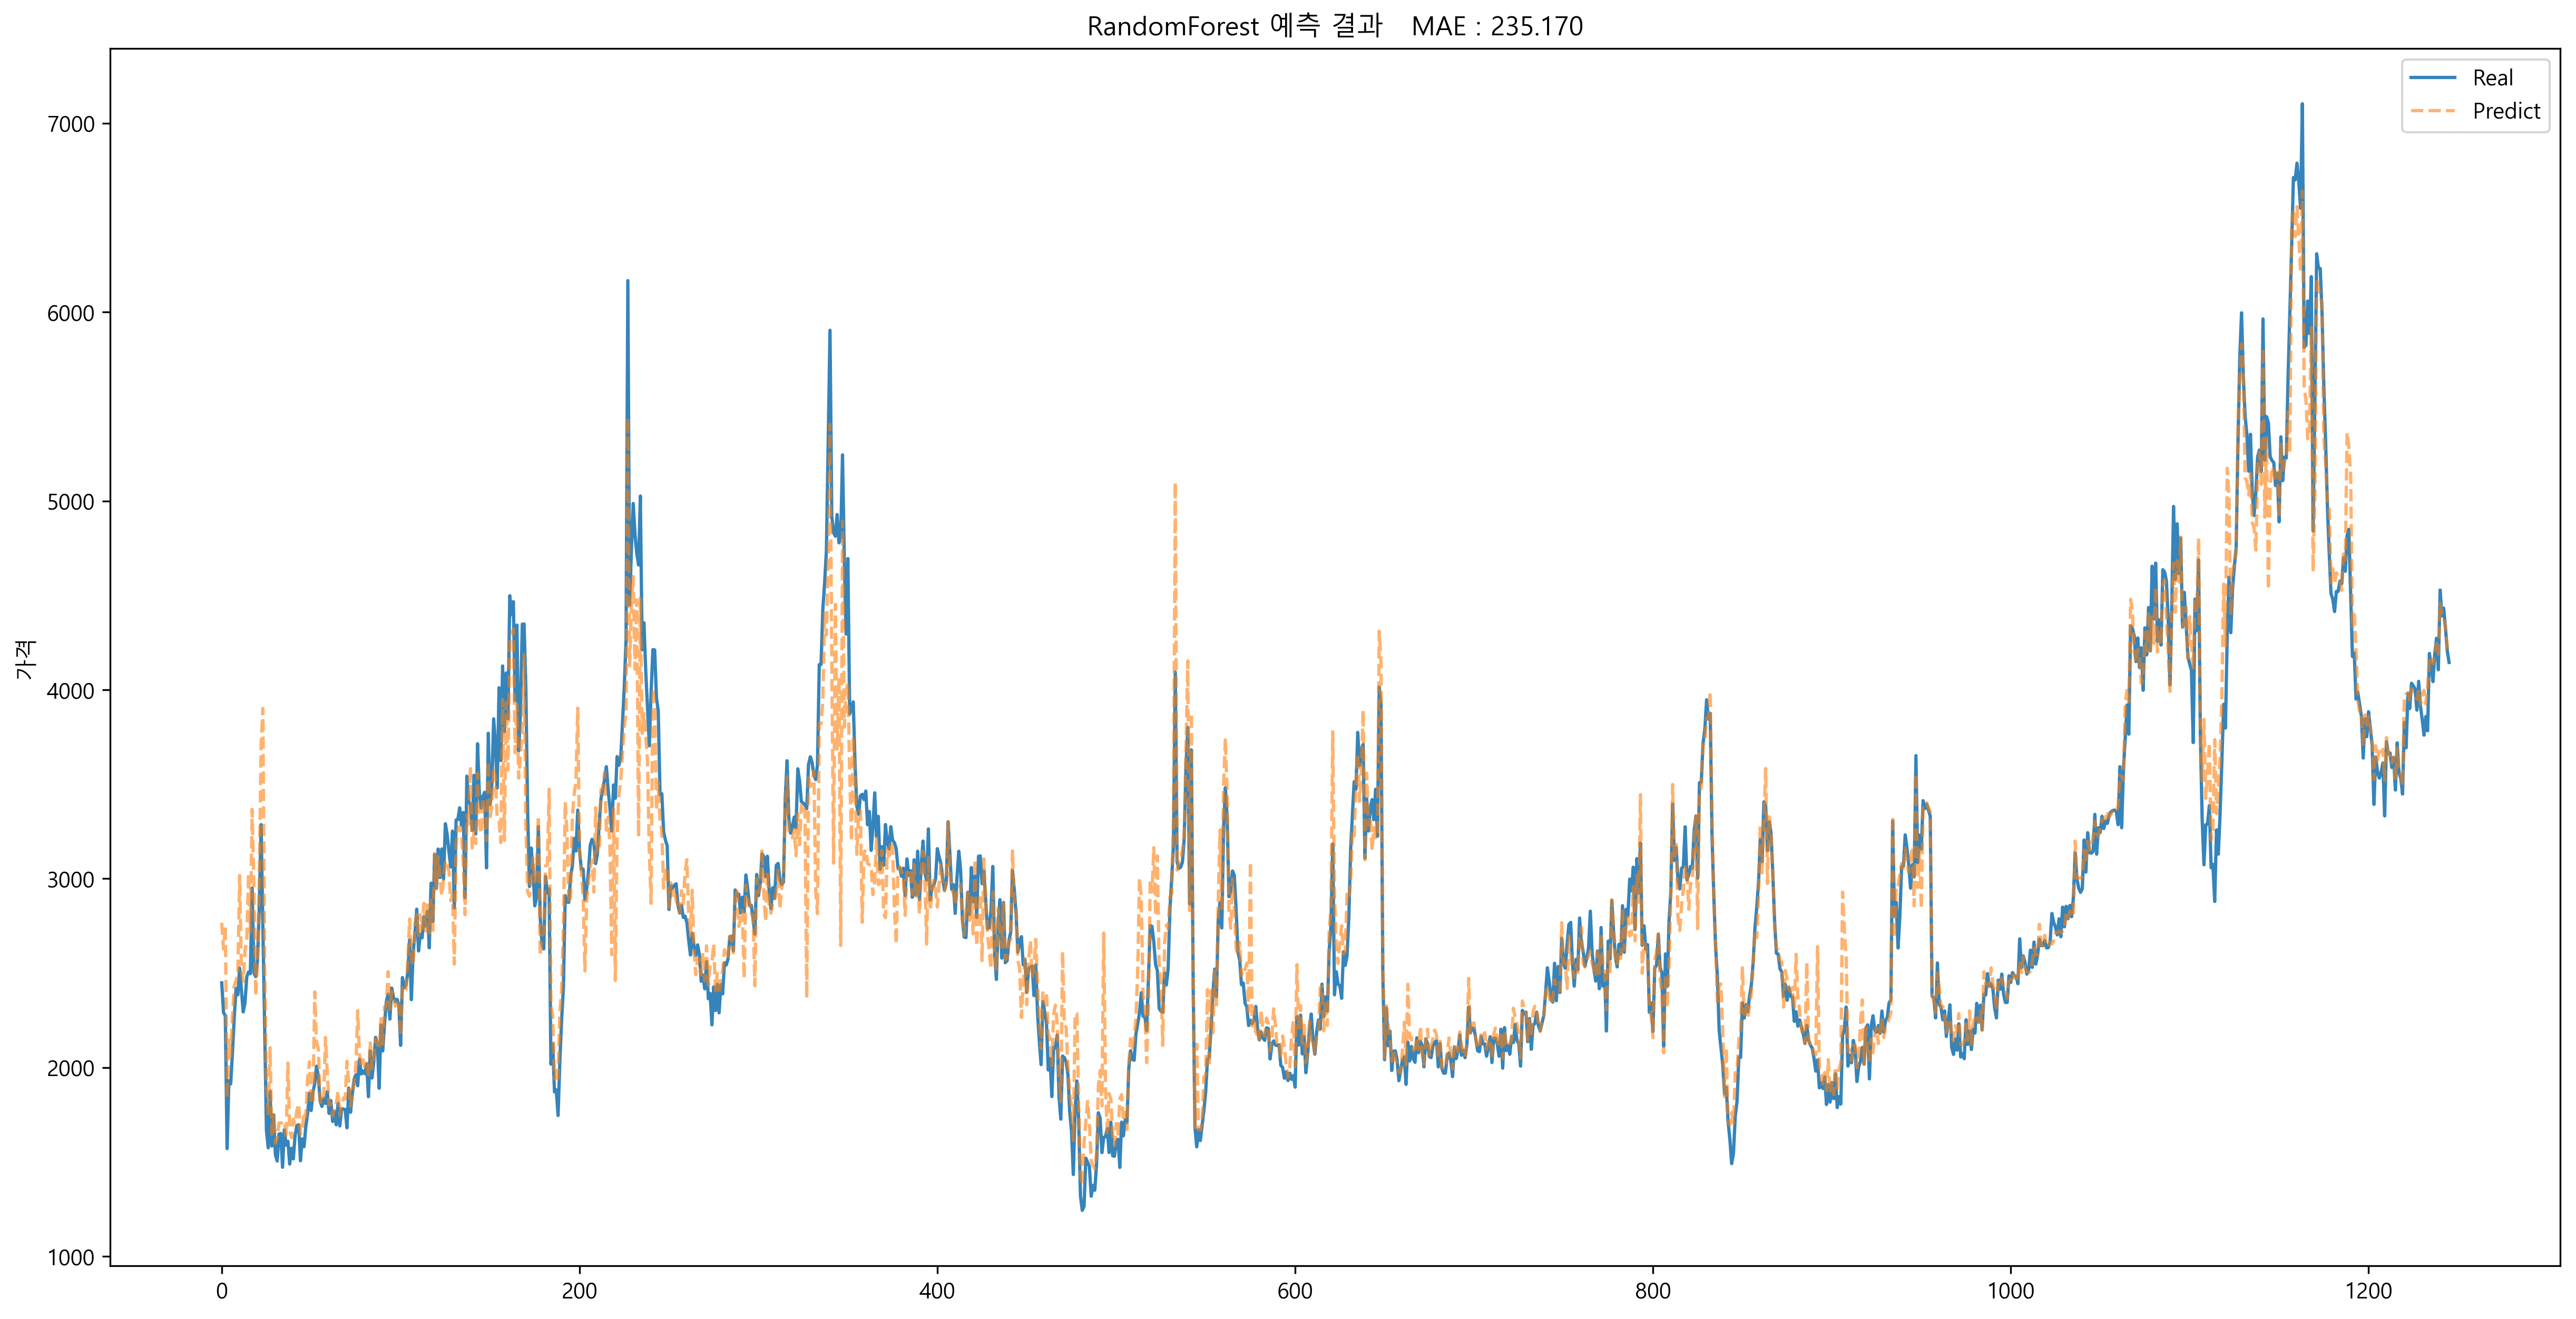

In [6]:
plt.figure(figsize=(20, 10), dpi=300)
plt.title('RandomForest 예측 결과'+   '   MAE : ' + str(mae)[:7])
plt.ylabel('가격')
plt.plot(np.array(y), alpha = 0.9, label = 'Real')
plt.plot(rf.predict(x), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

- 1주 후 예측

In [7]:
df['target'] = df['사과_가격(원/kg)'].shift(-7)
df.dropna(inplace=True)

feature = ['사과_거래량(kg)', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', 'year', 'month', 'day', 'resid']
x = df[feature]
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=42)
rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)
score = rf.score(x_test, y_test)
print("RandomForest 정확도: ", score)

RandomForest 정확도:  0.8306472489423969


In [8]:
train_score = rf.score(x_train, y_train)
test_score = rf.score(x_test, y_test)
print("Train Score:", train_score)
print("Test Score:", test_score)

y_pred = rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("MAE: ", mae)
print("RMSE: ", rmse)
print("R²: ", r2)

Train Score: 0.9782386332916861
Test Score: 0.8306472489423969
MSE:  134606.11387512746
MAE:  224.57280850629448
RMSE:  366.8870587457773
R²:  0.8306472489423969


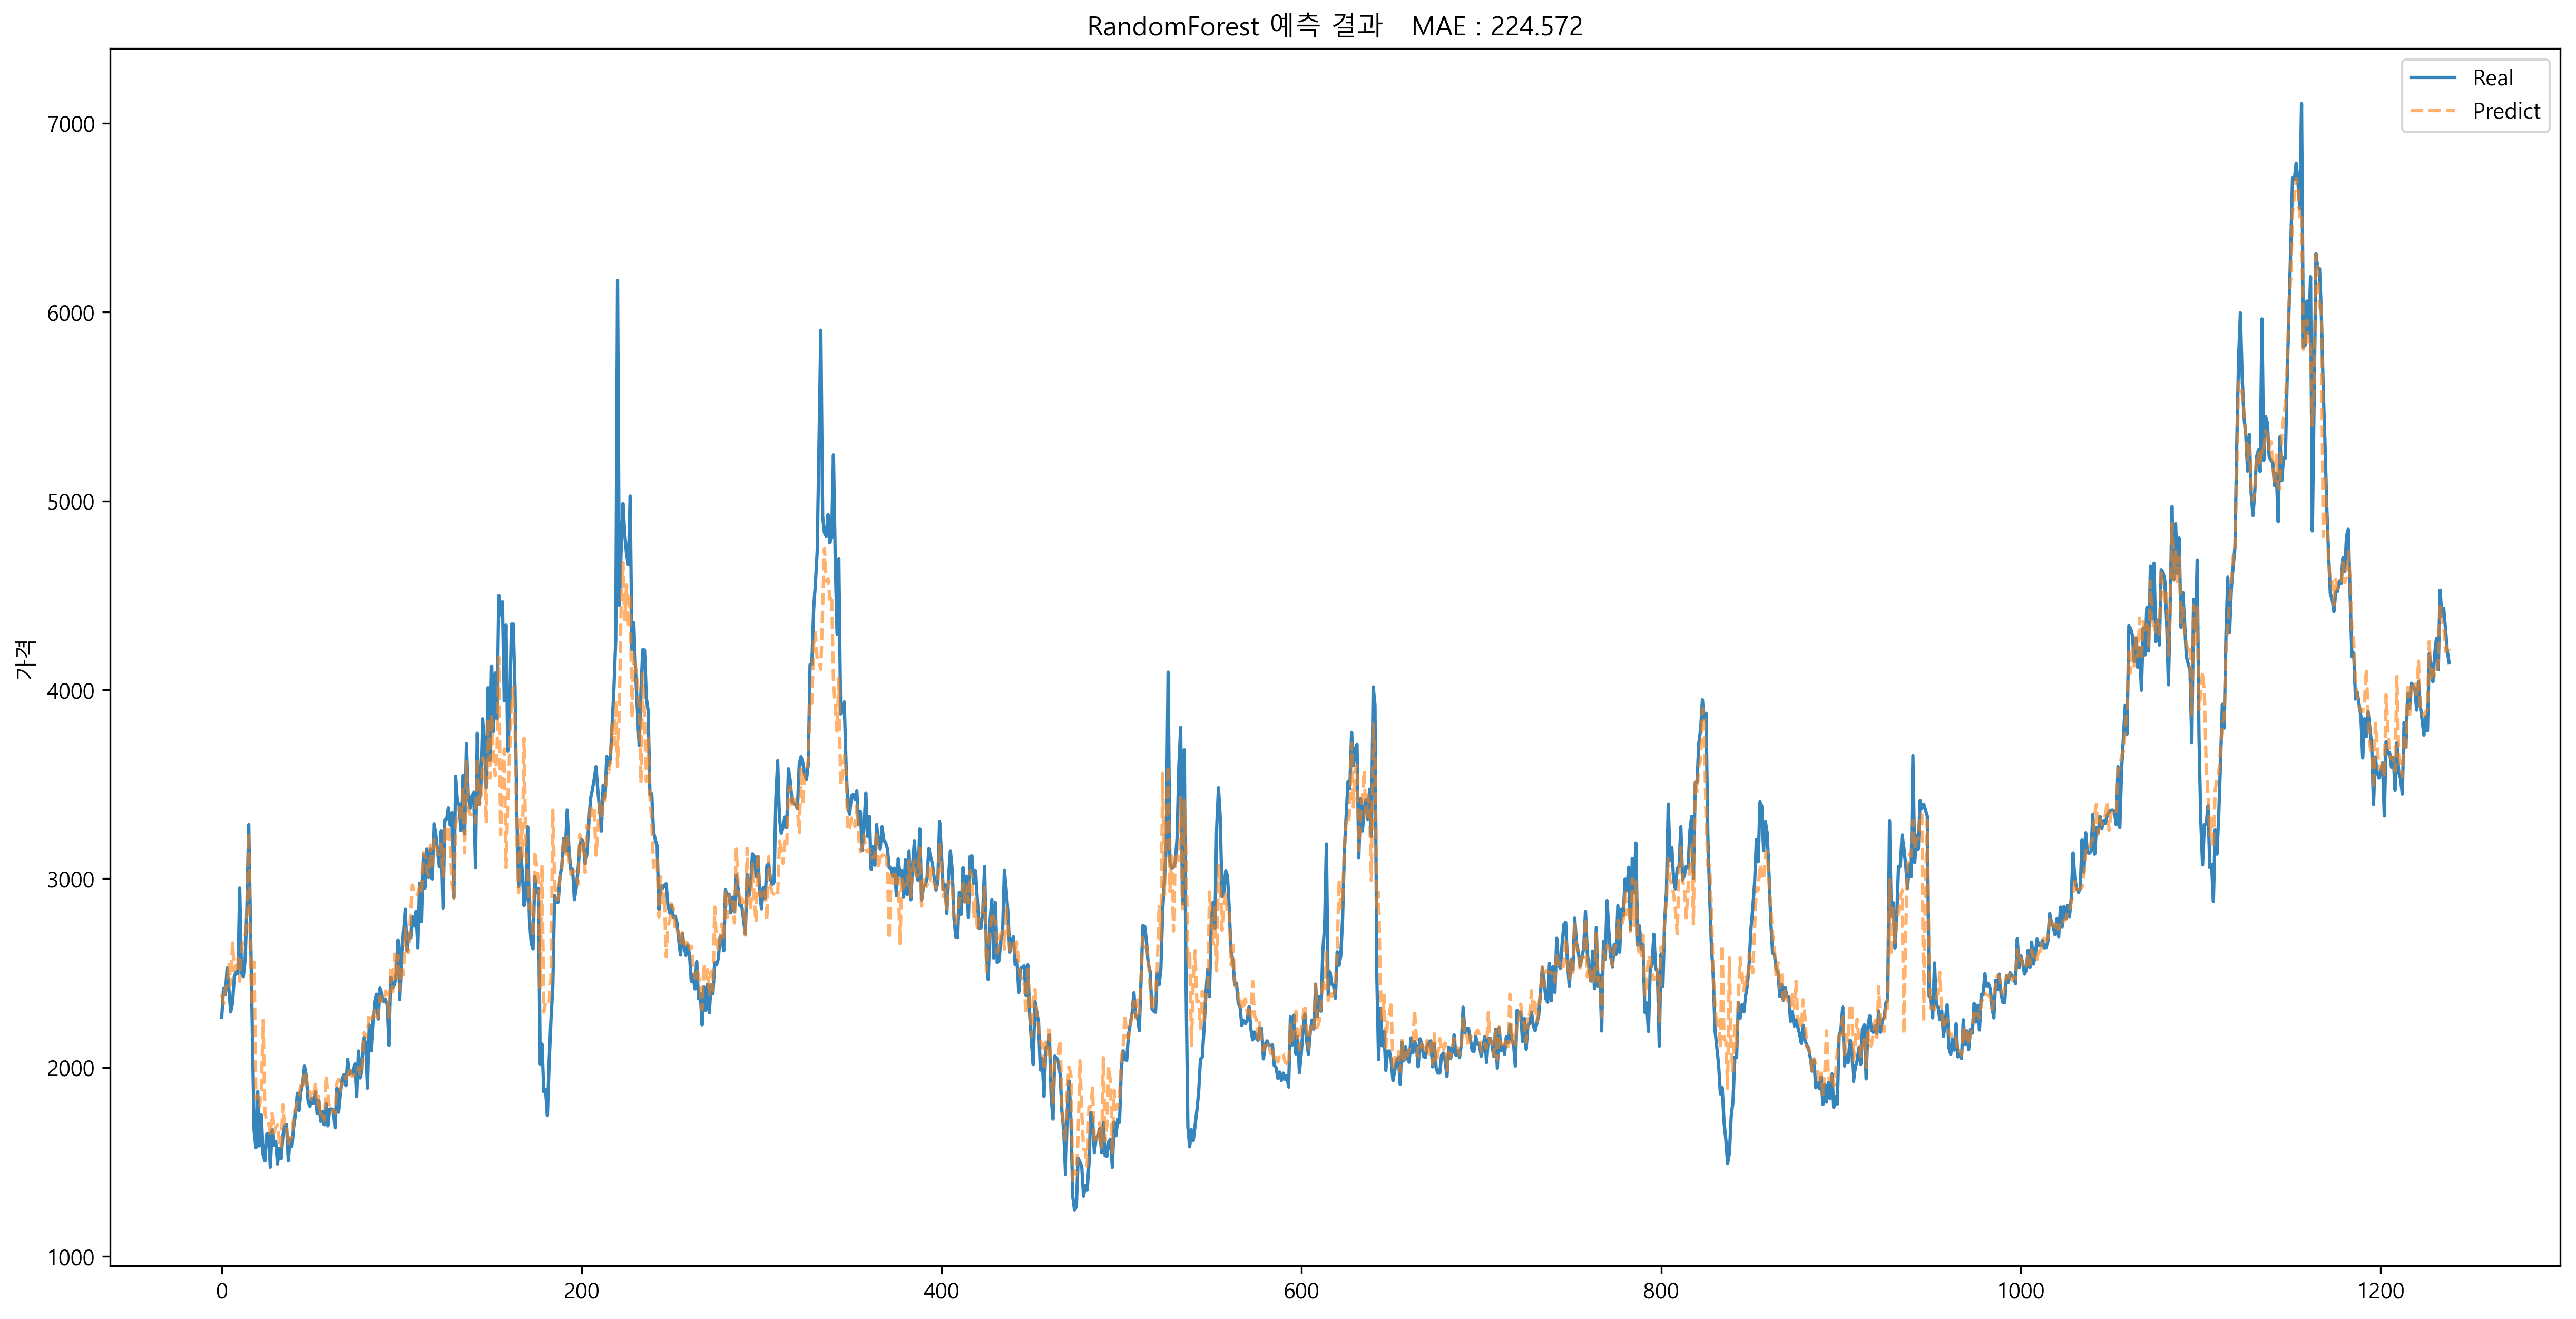

In [9]:
plt.figure(figsize=(20, 10), dpi=300)
plt.title('RandomForest 예측 결과'+   '   MAE : ' + str(mae)[:7])
plt.ylabel('가격')
plt.plot(np.array(y), alpha = 0.9, label = 'Real')
plt.plot(rf.predict(x), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()